In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.12/dist-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


In [3]:
import os
import tempfile

import anndata
import muon
import numpy as np
import pooch
import scanpy as sc
import scvi
import seaborn as sns
import torch

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


/usr/local/lib/python3.12/dist-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## Data load

In [5]:
# RNA only
pbmc3k_path = os.path.join(save_dir.name, "pbmc3k.h5ad")

pbmc3k = sc.read(filename=pbmc3k_path, backup_url="http://falexwolf.de/data/pbmc3k_raw.h5ad")
pbmc3k.var.head()

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

,gene_ids
index,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945


In [6]:
def download_data(
    save_path: str, fname: str = "pbmc5k_protein_filtered_feature_bc_matrix.h5"
) -> str:
    """Download the data files."""
    return pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5",
        known_hash="7695e6b1888bdae6f53b3a28a99f0a0cdf387d1685e330a597cdd4b5541f8abd",
        fname=fname,
        path=save_path,
    )

h5_path = download_data(save_dir.name)
pbmc5k = muon.read_10x_h5(h5_path)
pbmc5k.var_names_make_unique()
pbmc5k.var.head()

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:947: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.

,gene_ids,feature_types,genome,pattern,read,sequence
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,,,
FAM138A,ENSG00000237613,Gene Expression,GRCh38,,,
OR4F5,ENSG00000186092,Gene Expression,GRCh38,,,
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,,,
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,,,


In [19]:
adata = anndata.concat([pbmc3k, pbmc5k.mod["rna"]], join="inner", label="batch")
adata.obs.sample(n=5)


,batch
CAATGACAGGGTTGCA-1,1
CTGTGGGAGTGATCGG-1,1
CGGACTCTCCTCGT-1,0
AGGTCTAGTAGGGAGG-1,1
ATGACCACAGACCGCT-1,1


## Processing

In [20]:
print("# cells, # genes before filtering:", adata.shape)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

print("# cells, # genes after filtering:", adata.shape)

# cells, # genes before filtering: (7947, 20453)
# cells, # genes after filtering: (7947, 14309)


In [21]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

mdata = muon.MuData({"rna": adata.copy(), "log_norm_rna": adata.copy()}, axis=-1)
# Now rna is count-based and log_norm_rna is log-normalized
mdata.mod["rna"].X = mdata.mod["rna"].layers["counts"]
del mdata.mod["rna"].raw
del mdata.mod["rna"].layers["counts"]
del mdata.mod["log_norm_rna"].layers["counts"]
mdata

/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 7947 × 14309 (shared obs and var) 
  2 modalities
    rna:	7947 x 14309
      obs:	'batch', 'n_counts'
      var:	'n_counts'
      uns:	'log1p'
    log_norm_rna:	7947 x 14309
      obs:	'batch', 'n_counts'
      var:	'n_counts'
      uns:	'log1p'

In [23]:
print(adata.layers["counts"].sum())

37442544.0


In [14]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

model = scvi.model.SCVI(adata,n_latent=20, n_hidden=128)

model.train(
    max_epochs=500,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    accelerator="cuda",
    batch_size=256,
    check_val_every_n_epoch=1
)

/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.12/dist-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the 

Monitored metric elbo_validation did not improve in the last 15 records. Best score: 3846.254. Signaling Trainer to stop.


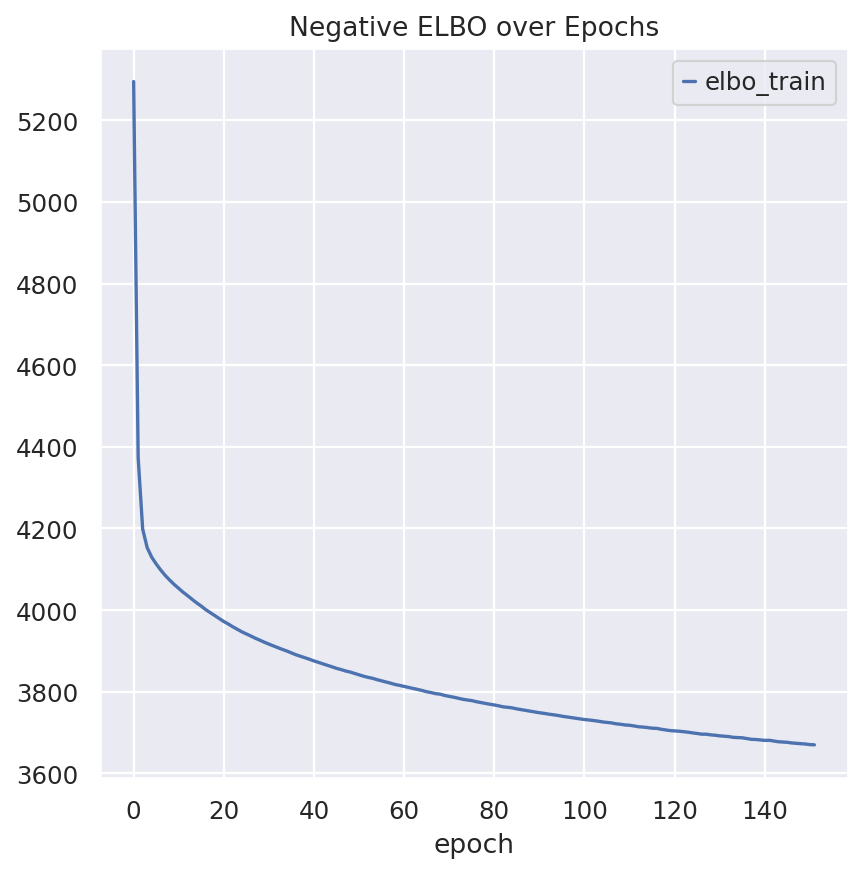

In [16]:
import matplotlib.pyplot as plt
model.history["elbo_train"].plot()
plt.title("Negative ELBO over Epochs")
#plt.yscale('log')
plt.show()

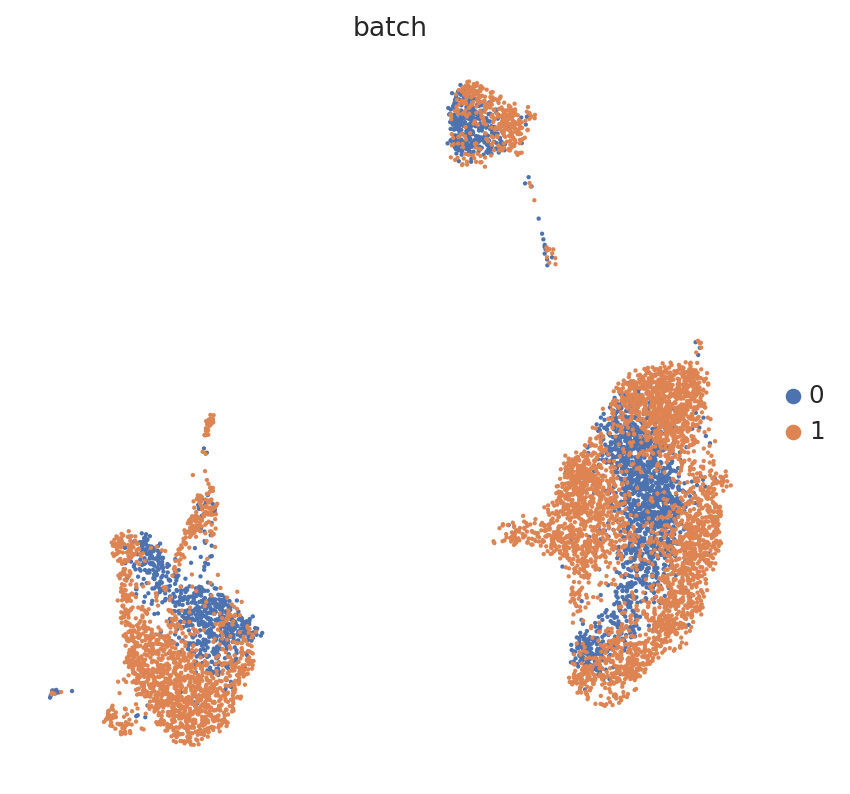

In [17]:
adata.obsm["X_scvi"] = model.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)

sc.pl.umap(adata, color="batch")

In [24]:
# totalVI requires dense protein data
pbmc5k.mod["prot"].X = (
    np.asarray(pbmc5k.mod["prot"].X.A)
    if hasattr(pbmc5k.mod["prot"].X, "A")
    else np.asarray(pbmc5k.mod["prot"].X.toarray())
)
scvi.model.TOTALVI.setup_mudata(
    pbmc5k,
    protein_layer=None,
    rna_layer=None,
    modalities={"protein_layer": "prot", "rna_layer": "rna"},
)

In [25]:
adata_pbm5k = pbmc5k.mod["rna"]
adata_pbm5k.obsm["prot"] = pbmc5k.mod["prot"].to_df()

scvi.model.TOTALVI.setup_anndata(
    adata_pbm5k,
    protein_expression_obsm_key="prot",
)

INFO     Using column names from columns of adata.obsm['prot']                                                     


/tmp/ipython-input-1267736657.py:4: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(


In [26]:
model = scvi.model.TOTALVI(adata_pbm5k)
model.view_anndata_setup(adata_pbm5k)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 820, in send
    msg = self.msg(
          ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 661, in msg
    header = self.msg_header(msg_type) if header is None else header
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 644, in msg_header
    return msg_header(self.msg_id, msg_type, self.username, self.session)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 275, in msg_header
    date

Anndata setup with scvi-tools version 1.4.1.

Setup via `TOTALVI.setup_anndata` with arguments:

{
│   'protein_expression_obsm_key': 'prot',
│   'protein_names_uns_key': None,
│   'batch_key': None,
│   'panel_key': None,
│   'layer': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 5247  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│        n_proteins        │  32   │
│          n_vars          │ 33538 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│   proteins   │    adata.obsm['prot']     │
└──────────────┴───────────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘